**14.2 Ridge Regression**

*Practice Activity*

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with
.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [92]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [93]:
# Importing the data
ames = pd.read_csv('/content/drive/My Drive/AmesHousing.csv')
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [94]:
# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [96]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Ridge Regression pipeline (alpha=1)
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # lambda=alpha
)

# OLS Regression pipeline
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
    ).set_output(transform="pandas")

# Performing cross-validation
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
linear_scores = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'r2')

print("Ridge Scores")
print(ridge_scores)
print()
print("Linear Scores")
print(linear_scores)
print()

# Fitting the models on the whole dataset
ridge_pipeline.fit(X, y)
lr_pipeline.fit(X, y)

# Getting the coefficients
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

Ridge Scores
[0.89627831 0.91741344 0.79268639 0.7825356  0.91432405]

Linear Scores
[-1.42602102e+21 -1.53036216e+21 -2.46556630e+20 -1.89368923e+22
 -1.29840327e+20]



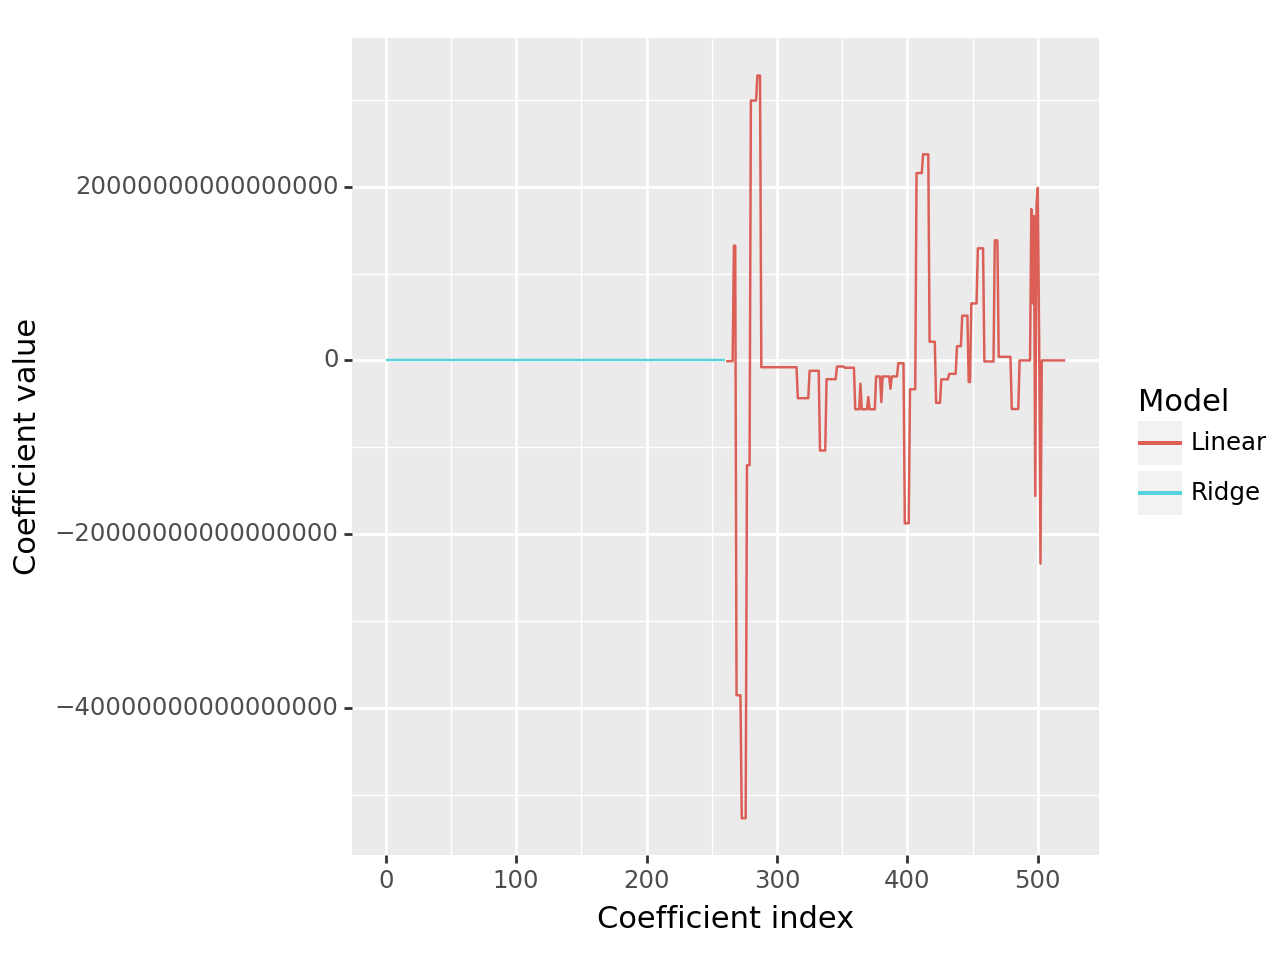

In [97]:
from plotnine import ggplot, aes, geom_line, labs

# Creating a dataframe for plotting
coefs_df = pd.DataFrame({'Ridge': ridge_coefs, 'Linear': linear_coefs})
coefs_df = coefs_df.melt(var_name='Model', value_name='Coefficient')

# Plotting the coefficients using plotnine
(ggplot(coefs_df, aes(x=np.arange(len(coefs_df)), y='Coefficient', color='Model'))
 + geom_line()
 + labs(x='Coefficient index', y='Coefficient value')
).draw()

*    The value of the coefficients for the Ridge Model were all close to 0, but the Linear Model fluctuated wildly.

**14.2.1 Ridge Tuning**

*Practice Activity*

Using the same pipeline as previously, perform tuning on
.

You should always try
 values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [101]:
from sklearn.model_selection import GridSearchCV

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Ridge Regression pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # lambda=alpha
    ).set_output(transform="pandas")

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv1 = GridSearchCV(ridge_pipeline, degrees, cv = 5, scoring='r2')

gscv1_fitted = gscv1.fit(X, y)

gscv1_fitted.cv_results_

{'mean_fit_time': array([0.16607604, 0.16938167, 0.13845968, 0.11480203, 0.10641112]),
 'std_fit_time': array([0.02498042, 0.01263271, 0.03364498, 0.01481388, 0.01055546]),
 'mean_score_time': array([0.11605306, 0.09219065, 0.05866947, 0.05773315, 0.05178938]),
 'std_score_time': array([0.01220666, 0.01446268, 0.01181751, 0.01536277, 0.01621355]),
 'param_ridge_regression__alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge_regression__alpha': 0.001},
  {'ridge_regression__alpha': 0.01},
  {'ridge_regression__alpha': 0.1},
  {'ridge_regression__alpha': 1},
  {'ridge_regression__alpha': 10}],
 'split0_test_score': array([0.89625688, 0.89629286, 0.89650815, 0.89627831, 0.89608143]),
 'split1_test_score': array([0.90973404, 0.90996518, 0.91183417, 0.91741344, 0.92124538]),
 'split2_test_score': array([0.78709147, 0.78719975, 0.78816023, 0.79268639, 0.79778627]),

In [102]:
gscv1_fitted.cv_results_['mean_test_score']

array([0.85242762, 0.8527045 , 0.85489446, 0.86064756, 0.86322424])

In [103]:
pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": gscv1_fitted.cv_results_['mean_test_score']})

,alphas,scores
0,0.001,0.852428
1,0.010,0.852705
2,0.100,0.854894
3,1.000,0.860648
4,10.000,0.863224


**14.3.1 LASSO**

*Practice Activity*

Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [104]:
from sklearn.linear_model import Lasso

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Lasso Regression pipeline
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]
    ).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='r2')

gscv2_fitted = gscv2.fit(X, y)

gscv2_fitted.cv_results_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.164e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.775e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.616e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

{'mean_fit_time': array([1.52049685, 0.95904999, 1.30656872, 0.90335412, 0.57919316]),
 'std_fit_time': array([0.85605475, 0.01820904, 0.27796352, 0.10160628, 0.29060937]),
 'mean_score_time': array([0.05650253, 0.03482141, 0.06377807, 0.03390527, 0.03540173]),
 'std_score_time': array([0.03984653, 0.00174763, 0.02353807, 0.00214636, 0.00159697]),
 'param_lasso_regression__alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso_regression__alpha': 0.001},
  {'lasso_regression__alpha': 0.01},
  {'lasso_regression__alpha': 0.1},
  {'lasso_regression__alpha': 1},
  {'lasso_regression__alpha': 10}],
 'split0_test_score': array([0.89620955, 0.89621358, 0.89626075, 0.89669836, 0.89926225]),
 'split1_test_score': array([0.90971785, 0.90972264, 0.90977757, 0.91031879, 0.9146269 ]),
 'split2_test_score': array([0.78801157, 0.78855116, 0.7928845 , 0.79362871, 0.79836024]),

In [105]:
gscv2_fitted.cv_results_['mean_test_score']

array([0.85395154, 0.85405602, 0.85489151, 0.8553934 , 0.85905996])

In [106]:
pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": gscv2_fitted.cv_results_['mean_test_score']})

,alphas,scores
0,0.001,0.853952
1,0.010,0.854056
2,0.100,0.854892
3,1.000,0.855393
4,10.000,0.859060


*    The lambda of 10 netted the highest mean R2 test score of 0.859060.

In [107]:
# Fitting the best Ridge model on the whole dataset
best_ridge_alpha = gscv1.best_params_['ridge_regression__alpha']
ridge_pipeline.set_params(ridge_regression__alpha=best_ridge_alpha)
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

# Fitting the best Lasso model on the whole dataset
best_lasso_alpha = gscv2.best_params_['lasso_regression__alpha']
lasso_pipeline.set_params(lasso_regression__alpha=best_lasso_alpha)
lasso_pipeline.fit(X, y)
lasso_coefs = lasso_pipeline.named_steps['lasso_regression'].coef_

# Fitting the OLS model on the whole dataset
lr_pipeline.fit(X, y)
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

# Creating a dataframe for the coefficients
coefs_df = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs,
    'Linear': linear_coefs
})

# Adding feature names as the index
coefs_df.index = feature_names

print(coefs_df)
print(coefs_df.describe())

                                  Ridge        Lasso        Linear
dummify__MS Zoning_C (all) -4389.639345 -5323.100163 -8.133954e+13
dummify__MS Zoning_FV       1822.197237     0.000000 -8.133954e+13
dummify__MS Zoning_I (all) -1189.029548    -0.000000 -8.133954e+13
dummify__MS Zoning_RH       4058.866485  3785.150692 -8.133954e+13
dummify__MS Zoning_RL       1974.971118  2037.680558 -8.133954e+13
...                                 ...          ...           ...
standardize__Screen Porch   3140.314292  2630.120227  2.724000e+03
standardize__Pool Area       451.932615  2547.482118  2.736000e+03
standardize__Misc Val      -4194.315053 -4912.558077 -5.178000e+03
standardize__Mo Sold        -667.085484  -739.831134 -7.680000e+02
standardize__Yr Sold       -5856.621507 -3824.197327 -6.420000e+03

[261 rows x 3 columns]
              Ridge          Lasso        Linear
count    261.000000     261.000000  2.610000e+02
mean     275.602398    -175.169453 -4.591728e+14
std     6685.746633   376

*    The OLS model's coefficients were huge compared to the other models. Fitting the full model using Ridge Regression and Lasso Regression tamed the coefficients tremendously. The Ridge model had the lowest standard deviation, as well as lower maximum and minimum values.

**14.3.3 Elastic Net**

*Practice Activity*

Create an Elastic Net pipeline, and tune
 and
.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [108]:
import numpy as np
from sklearn.linear_model import ElasticNet

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Elastic Net Regression pipeline
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

alphas = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.001, 0.01, 0.1]}

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='r2')

gscv3_fitted = gscv3.fit(X, y)

gscv3_fitted.cv_results_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.483e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.272e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.082e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

{'mean_fit_time': array([1.16695275, 0.94973474, 1.2658802 , 0.80875835, 0.93947988,
        1.18428588, 0.39384828, 0.22439694, 0.20410771, 0.14644799,
        0.142065  , 0.14111629, 0.12659678, 0.12047806, 0.12395616]),
 'std_fit_time': array([0.29306046, 0.04207608, 0.2758023 , 0.02269706, 0.30327882,
        0.09803768, 0.07457419, 0.01002186, 0.01463445, 0.01744352,
        0.01527434, 0.01667086, 0.00686999, 0.01232805, 0.01447237]),
 'mean_score_time': array([0.04453783, 0.03517613, 0.0629848 , 0.03400397, 0.04403534,
        0.08102837, 0.05893321, 0.03498249, 0.03340569, 0.03621683,
        0.03520131, 0.03423018, 0.03575931, 0.03343258, 0.03850965]),
 'std_score_time': array([0.01526808, 0.00340063, 0.02087239, 0.00150043, 0.01698932,
        0.00284555, 0.02224968, 0.00199845, 0.00062794, 0.00240554,
        0.0025709 , 0.00165192, 0.00107633, 0.00155021, 0.0033696 ]),
 'param_elastic_net__alpha': masked_array(data=[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1,
    

In [109]:
gscv3_fitted.cv_results_['mean_test_score']

array([0.8619473 , 0.86193571, 0.86181047, 0.86289744, 0.86290864,
       0.86301464, 0.85237546, 0.85244936, 0.8532095 , 0.81273444,
       0.81305931, 0.81632561, 0.53991817, 0.54195708, 0.56309514])

In [110]:
results = pd.DataFrame(gscv3_fitted.cv_results_)

# Extracting only the parameters and the mean test score
df_elastic = results.loc[:, ['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_test_score']]

print(df_elastic)

   param_elastic_net__alpha param_elastic_net__l1_ratio  mean_test_score
0                     0.001                       0.001         0.861947
1                     0.001                        0.01         0.861936
2                     0.001                         0.1         0.861810
3                      0.01                       0.001         0.862897
4                      0.01                        0.01         0.862909
5                      0.01                         0.1         0.863015
6                       0.1                       0.001         0.852375
7                       0.1                        0.01         0.852449
8                       0.1                         0.1         0.853209
9                         1                       0.001         0.812734
10                        1                        0.01         0.813059
11                        1                         0.1         0.816326
12                       10                       0

In [111]:
# Finding the row with the highest mean_test_score
best_row = results.loc[results['mean_test_score'].idxmax()]

# Extracting the best score and the corresponding parameters
best_score = best_row['mean_test_score']
best_params = best_row['params']

print(f"The best mean test score is {best_score}")
print(f"The best parameters are {best_params}")

The best mean test score is 0.8630146363355291
The best parameters are {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.1}


*Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.*

In [112]:
# Fitting the best Ridge model on the whole dataset
best_ridge_alpha = gscv1.best_params_['ridge_regression__alpha']
ridge_pipeline.set_params(ridge_regression__alpha=best_ridge_alpha)
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

# Fitting the best Lasso model on the whole dataset
best_lasso_alpha = gscv2.best_params_['lasso_regression__alpha']
lasso_pipeline.set_params(lasso_regression__alpha=best_lasso_alpha)
lasso_pipeline.fit(X, y)
lasso_coefs = lasso_pipeline.named_steps['lasso_regression'].coef_

# Fitting the best Elastic Net model on the whole dataset
best_elastic_alpha = gscv3.best_params_['elastic_net__alpha']
best_l1_ratio = gscv3.best_params_['elastic_net__l1_ratio']
elastic_net_pipeline.set_params(elastic_net__alpha=best_elastic_alpha, elastic_net__l1_ratio=best_l1_ratio)
elastic_net_pipeline.fit(X, y)
elastic_coefs = elastic_net_pipeline.named_steps['elastic_net'].coef_

# Fitting the Linear Regression model on the whole dataset
lr_pipeline.fit(X, y)
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

# Creating a dataframe for the coefficients
coefs_df1 = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs,
    'ElasticNet': elastic_coefs,
    'Linear': linear_coefs
})

# Adding feature names as the index
coefs_df1.index = feature_names

print(coefs_df1)
print(coefs_df1.describe())

                                  Ridge        Lasso   ElasticNet  \
dummify__MS Zoning_C (all) -4389.639345 -5323.100163 -2784.734855   
dummify__MS Zoning_FV       1822.197237     0.000000  1900.156402   
dummify__MS Zoning_I (all) -1189.029548    -0.000000  -527.141068   
dummify__MS Zoning_RH       4058.866485  3785.150692  2146.583933   
dummify__MS Zoning_RL       1974.971118  2037.680558  1864.215411   
...                                 ...          ...          ...   
standardize__Screen Porch   3140.314292  2630.120227  3182.266506   
standardize__Pool Area       451.932615  2547.482118   249.280705   
standardize__Misc Val      -4194.315053 -4912.558077 -4289.496914   
standardize__Mo Sold        -667.085484  -739.831134  -599.538530   
standardize__Yr Sold       -5856.621507 -3824.197327 -4401.947922   

                                  Linear  
dummify__MS Zoning_C (all) -8.133954e+13  
dummify__MS Zoning_FV      -8.133954e+13  
dummify__MS Zoning_I (all) -8.133954e+13  

*    The Elastic Net Regression Model yielded the best results with the lowest standard deviation, and lowest minimum and maximum values, when compared to the Ridge, Lasso, and OLS models.